1392778 - Izumi Alatriste

Gradient Boosting on Deceptive Opinion Spam (v1.4)
- Train/tune on folds 1–4 via Stratified CV; evaluate on fold 5
- Compare unigrams vs unigrams+bigrams

In [1]:
from pathlib import Path
import argparse
import sys
import zipfile
import re
from typing import Iterator, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    ConfusionMatrixDisplay,
)
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import binomtest              

In [2]:
LABEL_MAP = {"truthful_from_Web": 1, "deceptive_from_MTurk": 0}
POLS = {"negative_polarity"}
CLASS_NAMES = {0: "deceptive", 1: "truthful"}

In [3]:
def iter_review_files(data_path: Path) -> Iterator[Tuple[str, str]]:
    if data_path.suffix.lower() == ".zip":
        with zipfile.ZipFile(data_path, "r") as z:
            for name in z.namelist():
                if name.lower().endswith(".txt") and not name.endswith("/"):
                    try:
                        text = z.read(name).decode("utf-8", errors="ignore")
                    except Exception:
                        text = z.read(name).decode("latin-1", errors="ignore")
                    yield name, text
    else:
        for p in data_path.rglob("*.txt"):
            rel = p.relative_to(data_path).as_posix()
            try:
                text = p.read_text(encoding="utf-8", errors="ignore")
            except Exception:
                text = p.read_text(encoding="latin-1", errors="ignore")
            yield rel, text


In [4]:
def load_dataframe(data_path: Path) -> pd.DataFrame:
    """
    Build a DataFrame with columns: fold, label, text, path
    Detects fold and label from the last path components.
    """
    rows = []
    for rel_path, text in iter_review_files(data_path):
        parts = Path(rel_path).parts
        tail = parts[-5:] if len(parts) >= 5 else parts
        label_dir = None
        fold = None
        for i in range(len(tail)):
            if str(tail[i]).startswith("fold"):
                fold = str(tail[i])
            if "truthful" in str(tail[i]):
                label_dir = str(tail[i])
            if "deceptive" in str(tail[i]):
                label_dir = str(tail[i])

        if fold is None or label_dir is None:
            continue

        label = 1 if "truthful" in label_dir else 0
        fold_num = int(fold.replace("fold", ""))
        rows.append({"fold": fold_num, "label": label, "text": text, "path": rel_path})

    if not rows:
        raise RuntimeError(
            f"No reviews found under: {data_path}\n"
            "Check that you passed the *extracted* op_spam_v1.4 folder or the .zip itself."
        )

    df = pd.DataFrame(rows).sort_values(["fold"]).reset_index(drop=True)
    n = len(df)
    n_true = int(df["label"].sum())
    n_fake = n - n_true
    folds = sorted(df["fold"].unique().tolist())
    print(f"[load_dataframe] Loaded {n} reviews | truthful={n_true}, deceptive={n_fake} | folds={folds}", flush=True)
    return df

In [5]:
def vectorize_and_select(
    X_train_text: List[str],
    X_test_text: List[str],
    y_train: np.ndarray,
    ngram=(1, 1),
    min_df=2,
    k=2000,
):
    vec = CountVectorizer(ngram_range=ngram, min_df=min_df, lowercase=True, binary=True)
    Xtr = vec.fit_transform(X_train_text)
    Xte = vec.transform(X_test_text)
    k_eff = min(k, Xtr.shape[1])
    sel = SelectKBest(score_func=chi2, k=k_eff)
    Xtr_sel = sel.fit_transform(Xtr, y_train)
    Xte_sel = sel.transform(Xte)
    all_feats = np.array(vec.get_feature_names_out())
    mask = sel.get_support()
    feats_selected = all_feats[mask]
    return Xtr_sel, Xte_sel, feats_selected, vec, sel

In [6]:
def grid_search_gbc(X, y, grid: dict, cv_splits: int = 5, random_state: int = 0):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    best = {"cv_acc": -1.0, "params": None, "model": None}

    for n_estimators in grid.get("n_estimators", [200]):
        for learning_rate in grid.get("learning_rate", [0.1]):
            for max_depth in grid.get("max_depth", [3]):
                for subsample in grid.get("subsample", [1.0]):
                    for max_features in grid.get("max_features", [None]):
                        clf = GradientBoostingClassifier(
                            n_estimators=n_estimators,
                            learning_rate=learning_rate,
                            max_depth=max_depth,
                            subsample=subsample,
                            max_features=max_features,
                            random_state=random_state,
                        )
                        accs = cross_val_score(clf, X, y, scoring="accuracy", cv=skf)
                        mean_acc = float(np.mean(accs))

                        if mean_acc > best["cv_acc"]:
                            best["cv_acc"] = mean_acc
                            best["params"] = {
                                "n_estimators": n_estimators,
                                "learning_rate": learning_rate,
                                "max_depth": max_depth,
                                "subsample": subsample,
                                "max_features": max_features,
                            }

    bp = best["params"]
    clf = GradientBoostingClassifier(
        n_estimators=bp["n_estimators"],
        learning_rate=bp["learning_rate"],
        max_depth=bp["max_depth"],
        subsample=bp["subsample"],
        max_features=bp["max_features"],
        random_state=random_state,
    )
    clf.fit(X, y)
    best["model"] = clf
    return best

In [7]:
def eval_on_test(model, Xte, yte):
    """
    Returns dict with acc, precision, recall, f1, and y_pred.
    """
    y_pred = model.predict(Xte)
    acc = accuracy_score(yte, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        yte, y_pred, average="binary", pos_label=1, zero_division=0
    )
    return {"acc": acc, "precision": prec, "recall": rec, "f1": f1, "y_pred": y_pred}

In [8]:
def directional_top_terms_from_presence(Xtr, ytr, feat_names, topk=5):
    Xtr_bin = (Xtr > 0).astype(np.float32)
    ytr = np.asarray(ytr)

    mask1 = (ytr == 1)
    mask0 = (ytr == 0)

    p1 = Xtr_bin[mask1].mean(axis=0)
    p0 = Xtr_bin[mask0].mean(axis=0)
    p1 = np.asarray(p1).ravel()
    p0 = np.asarray(p0).ravel()

    diff = p1 - p0  # positive -> genuine-leaning; negative -> fake-leaning
    idx_sorted_pos = np.argsort(-diff)[:topk]
    idx_sorted_neg = np.argsort(diff)[:topk]

    genuine = [(feat_names[i], float(diff[i])) for i in idx_sorted_pos]
    fake = [(feat_names[i], float(diff[i])) for i in idx_sorted_neg]
    return fake, genuine

In [9]:
def _should_show():
    return any(m in sys.modules for m in ("ipykernel", "IPython"))


def plot_conf_matrix(y_true, y_pred, out_path: Path, title: str):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, values_format='d', colorbar=False)
    ax.set_title(title)
    fig.savefig(out_path, bbox_inches="tight")
    if _should_show():
        plt.show()
    plt.close(fig)

In [10]:
def plot_precision_recall(y_true, y_scores, out_path: Path, title: str):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    fig, ax = plt.subplots()
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"{title} (AP={ap:.3f})")
    fig.savefig(out_path, bbox_inches="tight")
    if _should_show():
        plt.show()
    plt.close(fig)


def plot_learning_curve(estimator, X, y, out_path: Path, title: str, random_state: int = 0):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring="accuracy",
        n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=random_state
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    fig, ax = plt.subplots()
    ax.plot(train_sizes, train_mean, marker="o", label="Train")
    ax.plot(train_sizes, val_mean, marker="s", label="Validation")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    ax.legend()
    fig.savefig(out_path, bbox_inches="tight")
    if _should_show():
        plt.show()
    plt.close(fig)

In [11]:
def get_args(argv=None):
    p = argparse.ArgumentParser(description="Gradient Boosting on Deceptive Opinion Spam (v1.4)")
    p.add_argument(
        "--data",
        type=str,
        default="/home/izujia/Desktop/Data Mining/AssigmentFiles/RF_GB/op_spam_v1.4",
        help="Path to 'op_spam_v1.4.zip' or extracted folder."
    )
    p.add_argument("--outdir", type=str, default="./gb_outputs", help="Output directory for CSVs & PNGs.")
    p.add_argument("--k_uni", type=int, default=2000, help="SelectKBest k for unigrams.")
    p.add_argument("--k_unibi", type=int, default=4000, help="SelectKBest k for uni+bi.")
    p.add_argument("--cv", type=int, default=5, help="CV folds for hyperparameter tuning.")
    if argv is None and any(m in sys.modules for m in ("ipykernel", "IPython")):
        argv = []
    return p.parse_args(argv)

[load_dataframe] Loaded 1600 reviews | truthful=800, deceptive=800 | folds=[1, 2, 3, 4, 5]


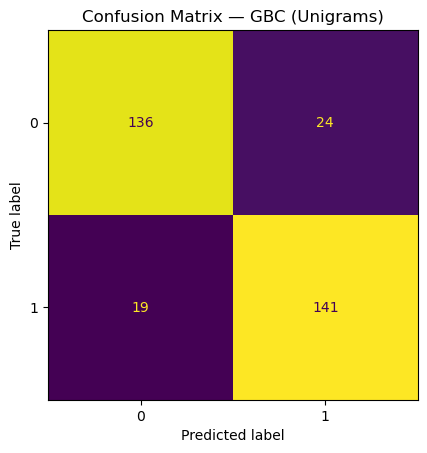

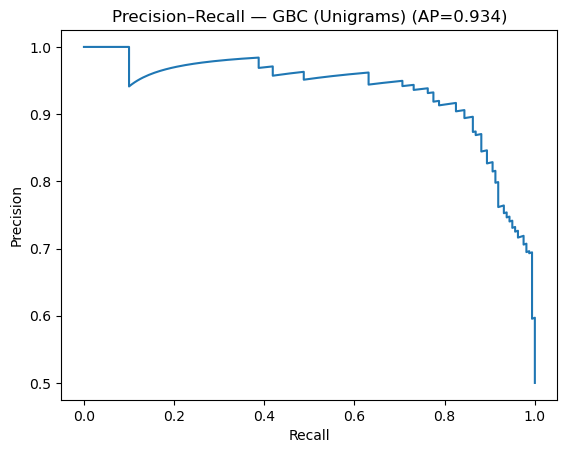

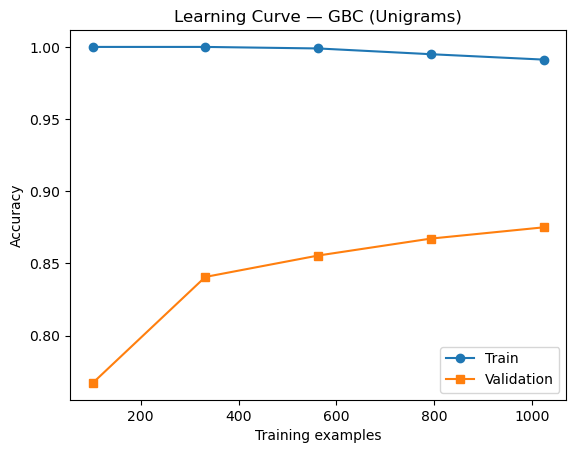

         Model    acc  precision  recall     f1  CV_ACC
GBC (unigrams) 0.8656     0.8545  0.8812 0.8677  0.8711

Top terms (unigrams):
 Fake-leaning term  direction(P1-P0) Genuine-leaning term  direction_g
          chicago         -0.334371             location     0.248438
               my         -0.234371                   we     0.181249
       experience         -0.126563                great     0.146876
               at         -0.103123                floor     0.143750
           luxury         -0.098437             michigan     0.121875

Saved files:
  gb_outputs/gb_metrics.csv
  gb_outputs/gb_unigram_top_terms.csv
  gb_outputs/gb_test_predictions.csv
  gb_outputs/cm_unigrams.png
  gb_outputs/pr_unigrams.png
  gb_outputs/lc_unigrams.png


In [13]:
def main(argv=None):
    args = get_args(argv)

    data_path = Path(args.data)
    out_dir = Path(args.outdir)
    out_dir.mkdir(parents=True, exist_ok=True)

    df = load_dataframe(data_path)
    train_df = df[df["fold"].isin([1, 2, 3, 4])].reset_index(drop=True)
    test_df  = df[df["fold"].isin([5])].reset_index(drop=True)

    X_train_text = train_df["text"].tolist()
    y_train = train_df["label"].values
    X_test_text  = test_df["text"].tolist()
    y_test  = test_df["label"].values

    # UNIGRAM ONLY 
    Xtr_uni, Xte_uni, feat_uni, vec_uni, sel_uni = vectorize_and_select(
        X_train_text, X_test_text, y_train, ngram=(1, 1), min_df=2, k=args.k_uni
    )
    grid = {
        "n_estimators": [200, 400],
        "learning_rate": [0.05, 0.1],
        "max_depth": [2, 3],
        "subsample": [0.7, 1.0],
        "max_features": [None, "sqrt"],
    }
    best_uni = grid_search_gbc(Xtr_uni, y_train, grid, cv_splits=args.cv)
    test_uni = eval_on_test(best_uni["model"], Xte_uni, y_test)
    fake_uni, genuine_uni = directional_top_terms_from_presence(Xtr_uni, y_train, feat_uni, topk=5)
    metrics_df = pd.DataFrame([
        {"Model": "GBC (unigrams)", **{k: round(v, 4) for k, v in test_uni.items() if k != "y_pred"},
         "CV_ACC": round(best_uni["cv_acc"], 4)},
    ])
    imp_df_uni = pd.DataFrame(fake_uni, columns=["Fake-leaning term", "direction(P1-P0)"]).join(
        pd.DataFrame(genuine_uni, columns=["Genuine-leaning term", "direction_g"]), how="outer"
    )
    metrics_path = out_dir / "gb_metrics.csv"
    imp_uni_path = out_dir / "gb_unigram_top_terms.csv"
    pred_path = out_dir / "gb_test_predictions.csv"

    metrics_df.to_csv(metrics_path, index=False)
    imp_df_uni.to_csv(imp_uni_path, index=False)

    pred_df = pd.DataFrame({
        "path": test_df["path"].values,
        "true_label": y_test,
        "pred_uni": test_uni["y_pred"],
    })
    pred_df.to_csv(pred_path, index=False)

    y_scores_uni = best_uni["model"].predict_proba(Xte_uni)[:, 1]

    cm_uni_path = out_dir / "cm_unigrams.png"
    pr_uni_path = out_dir / "pr_unigrams.png"
    lc_uni_path = out_dir / "lc_unigrams.png"

    plot_conf_matrix(y_test, test_uni["y_pred"], cm_uni_path, "Confusion Matrix — GBC (Unigrams)")
    plot_precision_recall(y_test, y_scores_uni, pr_uni_path, "Precision–Recall — GBC (Unigrams)")

    gbc_uni_for_lc = GradientBoostingClassifier(**best_uni["params"], random_state=0)
    plot_learning_curve(gbc_uni_for_lc, Xtr_uni, y_train, lc_uni_path, "Learning Curve — GBC (Unigrams)", random_state=0)

    print(metrics_df.to_string(index=False))
    print("\nTop terms (unigrams):\n", imp_df_uni.head(10).to_string(index=False))
    print(f"\nSaved files:\n  {metrics_path}\n  {imp_uni_path}\n  {pred_path}")
    print(f"  {cm_uni_path}\n  {pr_uni_path}\n  {lc_uni_path}")


if __name__ == "__main__":
    main([])